## Load library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy import stats
from scipy.signal import find_peaks
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score
from pickle import dump
from numpy.random import seed
import tensorflow
from sklearn.model_selection import ShuffleSplit
from numpy import quantile

rseed = 1
seed(rseed)
tensorflow.random.set_seed(rseed)
sns.set(style="whitegrid")

In [2]:
pd.options.display.max_columns = None

# Data preprocessing

In [3]:
data = pd.read_csv('creditcard.csv') # Load data
print(data.isnull().values.any()) # Check if the data has missing value

data.head()

False


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64


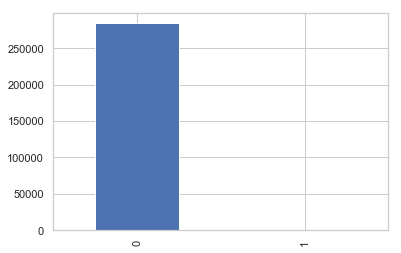

In [4]:
print(data["Class"].value_counts()) #Class distribution
data["Class"].value_counts().plot(kind='bar')

### Normalization

In [5]:
robscaler = preprocessing.RobustScaler()

data['sc_amount'] = robscaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['sc_time'] = robscaler.fit_transform(data['Time'].values.reshape(-1, 1))

data.drop(['Time', 'Amount'], axis=1, inplace=True)

In [6]:
scaled_amount = data['sc_amount']
scaled_time = data['sc_time']

data.drop(['sc_amount', 'sc_time'], axis=1, inplace=True)
data.insert(0, 'Amount', scaled_amount)
data.insert(1, 'Time', scaled_time)

In [7]:
data.head()

,Amount,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Data splitting

In [8]:
y = data["Class"].values
X_normal, X_fraud = data[y == 0].iloc[:,:-1], data[y == 1].iloc[:,:-1]
Y_normal, Y_fraud = np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])

X_normal = X_normal.sample(n=len(Y_fraud)*9, random_state=0)
X_normal = X_normal.reset_index(drop=True)

Y_normal = np.zeros(X_normal.shape[0])

outlier_fraction = len(Y_fraud)/float(len(Y_normal))
print("Outlier fraction:", outlier_fraction)
print("Fraud Cases : {}".format(len(Y_fraud)))
print("Valid Cases : {}".format(len(Y_normal)))

# Splitting Train & Test of Normal data
X_train_normal, X_test_normal, Y_train_normal, Y_test_normal = train_test_split(X_normal, Y_normal, test_size=0.2)
# Splitting Train & Test of Fraud data
X_train_fraud, X_test_fraud, Y_train_fraud, Y_test_fraud = train_test_split(X_fraud, Y_fraud, test_size=0.2)

# Combine Train Normal & Fraud data
X_train_all = np.append(X_train_normal, X_train_fraud, axis = 0)
Y_train_all = np.append(Y_train_normal, Y_train_fraud).astype(int)

# Combine Test Normal & Fraud data
X_test_all = np.append(X_test_normal, X_test_fraud, axis = 0)
Y_test_all = np.append(Y_test_normal, Y_test_fraud).astype(int)

Outlier fraction: 0.1111111111111111
Fraud Cases : 492
Valid Cases : 4428


In [9]:
X_normal.head()

,Amount,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-0.265633,0.910384,2.049094,0.186189,-1.707198,0.530768,0.160589,-1.448570,0.239310,-0.353611,0.634425,-0.471390,-0.349233,-0.073474,-0.303130,-0.664254,0.977499,0.157691,0.469860,0.446847,-0.502306,-0.232666,0.197782,0.741141,-0.009744,-0.085057,0.228384,-0.097292,-0.001028,-0.032390
1,-0.279746,0.426168,2.125540,-0.030714,-1.527653,0.121046,0.543172,-0.347988,0.157221,-0.229126,0.477999,0.046959,-1.314079,0.508379,0.891406,0.081326,0.065139,0.109356,-0.623472,-0.671603,0.435948,-0.125804,-0.336497,-0.838932,0.275173,0.049145,-0.156765,0.205919,-0.072321,-0.059009
2,26.768113,-0.683843,-4.155859,-5.705748,0.274699,-0.993262,-6.059393,5.210848,5.811316,0.367888,1.750710,-4.171672,-0.583742,0.346628,-0.719006,-0.899347,0.006643,-1.784000,1.457844,-0.952985,-1.315135,3.944592,1.371671,1.195815,4.188762,-1.091077,1.033044,0.224493,-0.486741,0.194275
3,4.164745,-0.222524,-0.566420,-0.579576,0.823503,-1.451240,-0.583587,0.206381,1.601392,-0.370446,-1.910354,0.252497,0.922508,-0.114149,1.008346,-0.282106,-0.246635,1.345463,-0.401365,-0.993434,1.474268,0.977739,-0.065082,-0.761357,0.641524,-0.568974,-0.053164,-0.690995,-0.228630,-0.157254
4,-0.146720,0.614822,0.060858,-0.261762,-1.699493,-1.202327,3.699527,3.196249,0.437208,0.421541,0.492435,-0.455964,0.028435,-0.329083,-0.552349,-1.568433,-0.440477,-0.296621,0.481656,-0.061843,-0.387865,-0.014550,0.008303,0.534602,0.089602,0.667918,0.017798,0.611584,-0.469946,-0.514370


In [10]:
Y_normal

array([0., 0., 0., ..., 0., 0., 0.])

# Model building & Evaluation

In [11]:
# GridSearch setting
cv = ShuffleSplit(test_size=0.2, n_splits=1, random_state=rseed)

def evaluation_matrix(Y_test_all, y_pred):
    print(classification_report(Y_test_all,y_pred))
    print("accuracy_score", accuracy_score(Y_test_all,y_pred))
    print("f1_score", f1_score(Y_test_all,y_pred,average=None))
    print("recall_score", recall_score(Y_test_all,y_pred,average=None))
    print("precision_score", precision_score(Y_test_all,y_pred,average=None))
    
    matrix = confusion_matrix(Y_test_all, y_pred)
    labels = ['Normal', 'Fraud']
    g=sns.heatmap(matrix,annot=True, cbar=False, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion matrix of IsolationForest')
    plt.show()

## Isolation forest (unsupervised)

In [12]:
param_grid = {'n_estimators': [100, 200],
            'max_samples': ['auto', 100],
            'contamination': [outlier_fraction, 'auto']}
f1_ms = make_scorer(f1_score, average='binary', pos_label=-1)

clf_if = IsolationForest(random_state=rseed)
clf_if = GridSearchCV(clf_if, param_grid, cv=cv, scoring=f1_ms, verbose=100)

# Provide class label with sklearn format
Y_train_all_2 = Y_train_all.copy()
Y_train_all_2[Y_train_all_2 == 1] = -1
Y_train_all_2[Y_train_all_2 == 0] = 1

clf_if.fit(X_train_all, Y_train_all_2)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] contamination=0.1111111111111111, max_samples=auto, n_estimators=100 
[CV]  contamination=0.1111111111111111, max_samples=auto, n_estimators=100, score=0.606, total=   0.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] contamination=0.1111111111111111, max_samples=auto, n_estimators=200 
[CV]  contamination=0.1111111111111111, max_samples=auto, n_estimators=200, score=0.618, total=   0.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[CV] contamination=0.1111111111111111, max_samples=100, n_estimators=100 
[CV]  contamination=0.1111111111111111, max_samples=100, n_estimators=100, score=0.650, total=   0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[CV] contamination=0.1111111111111111, max_samples=100, n_estimators=200 
[CV]  contamin

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=1, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=IsolationForest(behaviour='deprecated', bootstrap=False,
                                       contamination='auto', max_features=1.0,
                                       max_samples='auto', n_estimators=100,
                                       n_jobs=None, random_state=1, verbose=0,
                                       warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'contamination': [0.1111111111111111, 'auto'],
                         'max_samples': ['auto', 100],
                         'n_estimators': [100, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score, average=binary, pos_label=-1),
             verbose=100)

In [13]:
# Gridsearch Parameter Tuning result
print(clf_if.best_params_)
print(clf_if.best_score_)
dump(clf_if.best_estimator_, open('isolation_forest.pkl', 'wb'))

{'contamination': 'auto', 'max_samples': 100, 'n_estimators': 100}
0.7007299270072992


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       886
           1       0.76      0.72      0.74        99

    accuracy                           0.95       985
   macro avg       0.86      0.85      0.85       985
weighted avg       0.95      0.95      0.95       985

accuracy_score 0.9482233502538071
f1_score [0.97129994 0.7357513 ]
recall_score [0.97404063 0.71717172]
precision_score [0.96857464 0.75531915]


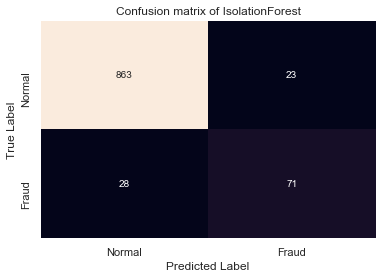

In [14]:
y_pred = clf_if.best_estimator_.predict(X_test_all)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

evaluation_matrix(Y_test_all, y_pred)

## Random forest (supervised)

In [15]:
param_grid = {'n_estimators': [100, 200],
              'criterion': ['gini', 'entropy'],
             'min_samples_split': [2, 5]}

f1_ms = make_scorer(f1_score, average='binary', pos_label=1)

clf_rf = RandomForestClassifier(random_state=rseed)
clf_rf = GridSearchCV(clf_rf, param_grid, cv=cv, scoring=f1_ms, verbose=100)
clf_rf.fit(X_train_all, Y_train_all)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] criterion=gini, min_samples_split=2, n_estimators=100 ...........
[CV]  criterion=gini, min_samples_split=2, n_estimators=100, score=0.905, total=   1.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[CV] criterion=gini, min_samples_split=2, n_estimators=200 ...........
[CV]  criterion=gini, min_samples_split=2, n_estimators=200, score=0.905, total=   2.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[CV] criterion=gini, min_samples_split=5, n_estimators=100 ...........
[CV]  criterion=gini, min_samples_split=5, n_estimators=100, score=0.905, total=   1.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s
[CV] criterion=gini, min_samples_split=5, n_estimators=200 ...........
[CV]  criterion=gini, min_samples_split=5, n_estimators=200, score=0.905

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=1, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sample...
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                     

In [16]:
# Gridsearch Parameter Tuning result
print(clf_rf.best_params_)
print(clf_rf.best_score_)
dump(clf_rf.best_estimator_, open('random_forest.pkl', 'wb'))

{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}
0.9119999999999999


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       886
           1       0.99      0.89      0.94        99

    accuracy                           0.99       985
   macro avg       0.99      0.94      0.96       985
weighted avg       0.99      0.99      0.99       985

accuracy_score 0.9878172588832488
f1_score [0.99326599 0.93617021]
recall_score [0.99887133 0.88888889]
precision_score [0.98772321 0.98876404]


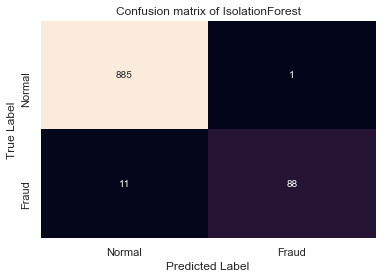

In [17]:
y_pred = clf_rf.best_estimator_.predict(X_test_all)
y_probs = clf_rf.best_estimator_.predict_proba(X_test_all)[:,1]

evaluation_matrix(Y_test_all, y_pred)

## One-class SVM (semi-supervised)

In [18]:
param_grid = {'kernel': ['rbf'],
             'gamma': ['scale', 0.1, 1],
             'nu': [0.1, 0.5, 1]}
f1_ms = make_scorer(f1_score)

clf_svm = OneClassSVM()
clf_svm = GridSearchCV(clf_svm, param_grid, cv=cv, scoring=f1_ms, verbose=100)

Y_train_normal_2 = Y_train_normal[:len(Y_train_normal)//10].copy()
Y_train_normal_2[Y_train_normal_2 == 1] = -1
Y_train_normal_2[Y_train_normal_2 == 0] = 1

clf_svm.fit(X_train_normal[:len(X_train_normal)//10], Y_train_normal_2)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] gamma=scale, kernel=rbf, nu=0.1 .................................
[CV] ..... gamma=scale, kernel=rbf, nu=0.1, score=0.924, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] gamma=scale, kernel=rbf, nu=0.5 .................................
[CV] ..... gamma=scale, kernel=rbf, nu=0.5, score=0.709, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] gamma=scale, kernel=rbf, nu=1 ...................................
[CV] ....... gamma=scale, kernel=rbf, nu=1, score=0.000, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] gamma=0.1, kernel=rbf, nu=0.1 ...................................
[CV] ....... gamma=0.1, kernel=rbf, nu=0.1, score=0.608, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=1, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3,
                                   gamma='scale', kernel='rbf', max_iter=-1,
                                   nu=0.5, shrinking=True, tol=0.001,
                                   verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': ['scale', 0.1, 1], 'kernel': ['rbf'],
                         'nu': [0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score), verbose=100)

In [19]:
# Gridsearch Parameter Tuning result
print(clf_svm.best_params_)
print(clf_svm.best_score_)
dump(clf_svm.best_estimator_, open('oneclass_svm.pkl', 'wb'))

{'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1}
0.9242424242424242


              precision    recall  f1-score   support

           0       0.99      0.87      0.93       886
           1       0.45      0.94      0.61        99

    accuracy                           0.88       985
   macro avg       0.72      0.91      0.77       985
weighted avg       0.94      0.88      0.90       985

accuracy_score 0.8781725888324873
f1_score [0.92788462 0.60784314]
recall_score [0.87133183 0.93939394]
precision_score [0.99228792 0.44927536]


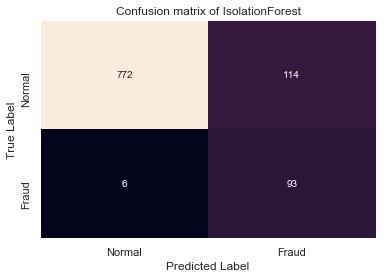

In [20]:
y_pred = clf_svm.best_estimator_.predict(X_test_all)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

evaluation_matrix(Y_test_all, y_pred)

## One-class Autoencoder
1. Hybrid (semi-supervised & supervised): encoder + classifier
1. Semi-supervised: using threshold

In [21]:
def create_model(optimizer='Adam', encoded_neuron=32):
    input_layer = Input(shape=(X_train_normal.shape[1],))

    ## encoding part
    encoded = Dense(encoded_neuron*4, activation='relu')(input_layer)
    encoded = Dense(encoded_neuron*2, activation='relu')(encoded)
    encoded = Dense(encoded_neuron, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(encoded_neuron, activation='relu')(encoded)
    decoded = Dense(encoded_neuron*2, activation='relu')(decoded)
    decoded = Dense(encoded_neuron*4, activation='relu')(decoded)

    ## output layer
    output_layer = Dense(X_train_normal.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer=optimizer, loss="mse")
    
    return autoencoder

In [22]:
params = {'optimizer': ['Adam', 'SGD'],
          'encoded_neuron': [8, 16, 32]}

autoencoder = KerasRegressor(build_fn=create_model)

autoencoder_grid = GridSearchCV(autoencoder, param_grid=params, cv=cv, verbose=100, scoring='neg_mean_squared_error') 

autoencoder_grid.fit(X_train_normal, X_train_normal, shuffle=True, batch_size=100, epochs=100)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] encoded_neuron=8, optimizer=Adam ................................
Train on 2833 samples
Epoch 1/100
2833/2833 [==============================] - 0s 34us/sample - loss: 1.4022
Epoch 2/100
2833/2833 [==============================] - 0s 13us/sample - loss: 1.3090
Epoch 3/100
2833/2833 [==============================] - 0s 14us/sample - loss: 1.2058
Epoch 4/100
2833/2833 [==============================] - 0s 14us/sample - loss: 1.1755
Epoch 5/100
2833/2833 [==============================] - 0s 14us/sample - loss: 1.1582
Epoch 6/100
2833/2833 [==============================] - 0s 13us/sample - loss: 1.1462
Epoch 7/100
2833/2833 [==============================] - 0s 13us/sample - loss: 1.1345
Epoch 8/100
2833/2833 [==============================] - 0s 13us/sample - loss: 1.1199
Epoch 9/100
2833/2833 [==============================] - 0s 12us/sample

2833/2833 [==============================] - 0s 13us/sample - loss: 1.0209
Epoch 90/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.0204
Epoch 91/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.0201
Epoch 92/100
2833/2833 [==============================] - 0s 13us/sample - loss: 1.0203
Epoch 93/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.0198
Epoch 94/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.0193
Epoch 95/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.0189
Epoch 96/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.0187
Epoch 97/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.0187
Epoch 98/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.0184
Epoch 99/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.0180
Epoch 100/100
2833/2833 [====================

2833/2833 [==============================] - 0s 11us/sample - loss: 1.2033
Epoch 76/100
2833/2833 [==============================] - 0s 11us/sample - loss: 1.2021
Epoch 77/100
2833/2833 [==============================] - 0s 11us/sample - loss: 1.2009
Epoch 78/100
2833/2833 [==============================] - 0s 11us/sample - loss: 1.1999
Epoch 79/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.1989
Epoch 80/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.1980
Epoch 81/100
2833/2833 [==============================] - 0s 11us/sample - loss: 1.1972
Epoch 82/100
2833/2833 [==============================] - 0s 11us/sample - loss: 1.1964
Epoch 83/100
2833/2833 [==============================] - 0s 11us/sample - loss: 1.1957
Epoch 84/100
2833/2833 [==============================] - 0s 11us/sample - loss: 1.1950
Epoch 85/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.1944
Epoch 86/100
2833/2833 [=====================

2833/2833 [==============================] - 0s 13us/sample - loss: 0.9606
Epoch 62/100
2833/2833 [==============================] - 0s 14us/sample - loss: 0.9611
Epoch 63/100
2833/2833 [==============================] - 0s 13us/sample - loss: 0.9599
Epoch 64/100
2833/2833 [==============================] - 0s 13us/sample - loss: 0.9595
Epoch 65/100
2833/2833 [==============================] - 0s 16us/sample - loss: 0.9594
Epoch 66/100
2833/2833 [==============================] - 0s 13us/sample - loss: 0.9596
Epoch 67/100
2833/2833 [==============================] - 0s 14us/sample - loss: 0.9586
Epoch 68/100
2833/2833 [==============================] - 0s 13us/sample - loss: 0.9589
Epoch 69/100
2833/2833 [==============================] - 0s 13us/sample - loss: 0.9586
Epoch 70/100
2833/2833 [==============================] - 0s 14us/sample - loss: 0.9577
Epoch 71/100
2833/2833 [==============================] - 0s 16us/sample - loss: 0.9573
Epoch 72/100
2833/2833 [=====================

2833/2833 [==============================] - 0s 12us/sample - loss: 1.3275
Epoch 48/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.3218
Epoch 49/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.3158
Epoch 50/100
2833/2833 [==============================] - 0s 13us/sample - loss: 1.3094
Epoch 51/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.3026
Epoch 52/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.2957
Epoch 53/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.2886
Epoch 54/100
2833/2833 [==============================] - 0s 14us/sample - loss: 1.2814
Epoch 55/100
2833/2833 [==============================] - 0s 14us/sample - loss: 1.2742
Epoch 56/100
2833/2833 [==============================] - 0s 15us/sample - loss: 1.2670
Epoch 57/100
2833/2833 [==============================] - 0s 12us/sample - loss: 1.2600
Epoch 58/100
2833/2833 [=====================

2833/2833 [==============================] - 0s 19us/sample - loss: 0.9121
Epoch 34/100
2833/2833 [==============================] - 0s 18us/sample - loss: 0.9113
Epoch 35/100
2833/2833 [==============================] - 0s 19us/sample - loss: 0.9096
Epoch 36/100
2833/2833 [==============================] - 0s 16us/sample - loss: 0.9094
Epoch 37/100
2833/2833 [==============================] - 0s 16us/sample - loss: 0.9090
Epoch 38/100
2833/2833 [==============================] - 0s 16us/sample - loss: 0.9070
Epoch 39/100
2833/2833 [==============================] - 0s 16us/sample - loss: 0.9069
Epoch 40/100
2833/2833 [==============================] - 0s 16us/sample - loss: 0.9030
Epoch 41/100
2833/2833 [==============================] - 0s 16us/sample - loss: 0.9024
Epoch 42/100
2833/2833 [==============================] - 0s 16us/sample - loss: 0.9015
Epoch 43/100
2833/2833 [==============================] - 0s 15us/sample - loss: 0.9003
Epoch 44/100
2833/2833 [=====================

2833/2833 [==============================] - 0s 17us/sample - loss: 1.3784
Epoch 20/100
2833/2833 [==============================] - 0s 16us/sample - loss: 1.3736
Epoch 21/100
2833/2833 [==============================] - 0s 15us/sample - loss: 1.3684
Epoch 22/100
2833/2833 [==============================] - 0s 17us/sample - loss: 1.3627
Epoch 23/100
2833/2833 [==============================] - 0s 16us/sample - loss: 1.3566
Epoch 24/100
2833/2833 [==============================] - 0s 15us/sample - loss: 1.3500
Epoch 25/100
2833/2833 [==============================] - 0s 16us/sample - loss: 1.3429
Epoch 26/100
2833/2833 [==============================] - 0s 16us/sample - loss: 1.3354
Epoch 27/100
2833/2833 [==============================] - 0s 17us/sample - loss: 1.3274
Epoch 28/100
2833/2833 [==============================] - 0s 15us/sample - loss: 1.3189
Epoch 29/100
2833/2833 [==============================] - 0s 14us/sample - loss: 1.3101
Epoch 30/100
2833/2833 [=====================

3542/3542 [==============================] - 0s 19us/sample - loss: 1.0689
Epoch 6/100
3542/3542 [==============================] - 0s 18us/sample - loss: 1.0578
Epoch 7/100
3542/3542 [==============================] - 0s 17us/sample - loss: 1.0517
Epoch 8/100
3542/3542 [==============================] - 0s 17us/sample - loss: 1.0469
Epoch 9/100
3542/3542 [==============================] - 0s 19us/sample - loss: 1.0416
Epoch 10/100
3542/3542 [==============================] - 0s 16us/sample - loss: 1.0376
Epoch 11/100
3542/3542 [==============================] - 0s 16us/sample - loss: 1.0325
Epoch 12/100
3542/3542 [==============================] - 0s 17us/sample - loss: 1.0291
Epoch 13/100
3542/3542 [==============================] - 0s 19us/sample - loss: 1.0257
Epoch 14/100
3542/3542 [==============================] - 0s 18us/sample - loss: 1.0232
Epoch 15/100
3542/3542 [==============================] - 0s 18us/sample - loss: 1.0203
Epoch 16/100
3542/3542 [=========================

3542/3542 [==============================] - 0s 20us/sample - loss: 0.9336
Epoch 99/100
3542/3542 [==============================] - 0s 21us/sample - loss: 0.9335
Epoch 100/100
3542/3542 [==============================] - 0s 19us/sample - loss: 0.9337


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=1, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000028A08C55748>,
             iid='deprecated', n_jobs=None,
             param_grid={'encoded_neuron': [8, 16, 32],
                         'optimizer': ['Adam', 'SGD']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=100)

In [23]:
# Gridsearch Parameter Tuning result
print(autoencoder_grid.best_params_)
print(autoencoder_grid.best_score_)
autoencoder_grid.best_estimator_.model.save('oneclass_ae.h5')

{'encoded_neuron': 32, 'optimizer': 'Adam'}
-1.066200063412255


### Hybrid (semi-supervised & supervised): encoder + classifier

In [24]:
# Encoder
encoder = Sequential()
encoder.add(autoencoder_grid.best_estimator_.model.layers[0])
encoder.add(autoencoder_grid.best_estimator_.model.layers[1])
encoder.add(autoencoder_grid.best_estimator_.model.layers[2])

train_all_rep = encoder.predict(X_train_all)
test_all_rep = encoder.predict(X_test_all)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       886
           1       0.95      0.89      0.92        99

    accuracy                           0.98       985
   macro avg       0.97      0.94      0.95       985
weighted avg       0.98      0.98      0.98       985

accuracy_score 0.983756345177665
f1_score [0.99100112 0.91666667]
recall_score [0.99435666 0.88888889]
precision_score [0.98766816 0.94623656]


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


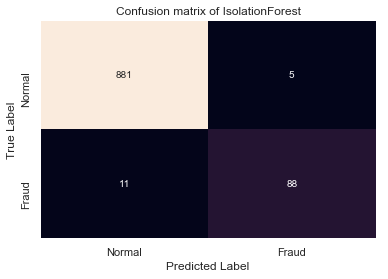

In [25]:
# classifier
clf = LogisticRegression().fit(train_all_rep, Y_train_all)
y_pred = clf.predict(test_all_rep)
evaluation_matrix(Y_test_all, y_pred)

### Semi-supervised: error threshold-based

In [26]:
# Get reconstruction error of train normal data
pred = autoencoder_grid.best_estimator_.model.predict(X_train_normal)
mse = np.mean(np.power(X_train_normal - pred, 2), axis=1)

error_train = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_train_normal})
error_train.head()

,reconstruction_error,true_class
3460,0.167702,0.0
943,0.966008,0.0
1004,0.518926,0.0
3393,0.109951,0.0
321,0.272342,0.0


In [27]:
# Get reconstruction error of train data
pred = autoencoder_grid.best_estimator_.model.predict(X_test_all)
mse = np.mean(np.power(X_test_all - pred, 2), axis=1)

error_test = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_test_all})
error_test.head()

,reconstruction_error,true_class
0,0.204241,0
1,0.649825,0
2,3.195262,0
3,0.811806,0
4,1.187094,0


In [28]:
error_test_normal = error_test.iloc[:len(Y_test_all)-len(Y_test_fraud),0]
error_test_fraud = error_test.iloc[len(Y_test_all)-len(Y_test_fraud):,0]

print(max(error_test_normal))
print(min(error_test_fraud))

79.72295600036855
0.29826099455968935


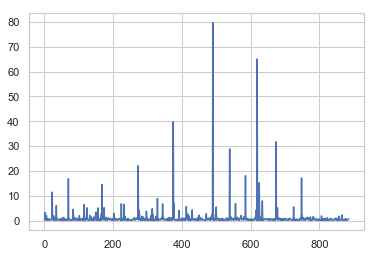

In [29]:
error_test_normal.plot()

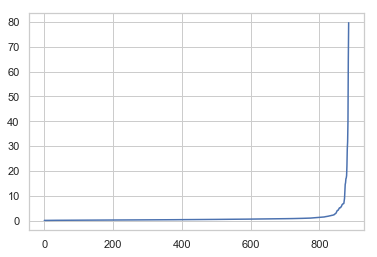

In [31]:
err_normal_sorted = sorted(error_test_normal)
err_normal_sorted = pd.Series(err_normal_sorted)
err_normal_sorted.plot()

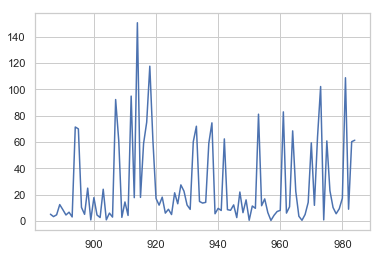

In [35]:
error_test_fraud.plot()

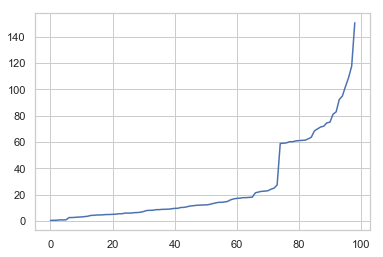

In [34]:
err_test_fraud_sorted = sorted(error_test_fraud)
err_test_fraud_sorted = pd.Series(err_test_fraud_sorted)
err_test_fraud_sorted.plot()

In [46]:
# Get maximum error as threshold
threshold = quantile(error_train['reconstruction_error'].values, 0.8)
threshold

0.7634599070060988

              precision    recall  f1-score   support

           0       0.99      0.80      0.89       886
           1       0.35      0.94      0.51        99

    accuracy                           0.82       985
   macro avg       0.67      0.87      0.70       985
weighted avg       0.93      0.82      0.85       985

accuracy_score 0.8162436548223351
f1_score [0.88708671 0.50681199]
recall_score [0.80248307 0.93939394]
precision_score [0.9916318  0.34701493]


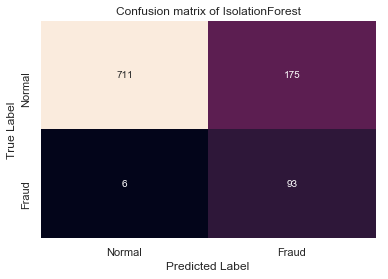

In [47]:
# prediction
y_pred = [1 if e > threshold else 0 for e in error_test.reconstruction_error.values]
evaluation_matrix(error_test.true_class, y_pred)